# Пример использования библиотеки BigARTM для тематического моделирования

**BigARTM 0.9.0**

Импортируем BigARTM:

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100)

В следующий раз данные можно считывать уже из батчей:

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [50]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, cache_theta=True)
# число после названия модальностей - это их веса

In [51]:
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

Создаем словарь и инициализируем модель с его помощью

In [8]:
#model_artm.gather_dictionary('dictionary', batch_vectorizer.data_path)

AttributeError: 'ARTM' object has no attribute 'gather_dictionary'

In [52]:
dictionary = artm.Dictionary()
dictionary.gather(data_path="school_batches")

In [53]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               #use_unigram_document_model=False,
                                               dictionary=dictionary))

In [54]:
model_artm.initialize(dictionary)

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [55]:
model_artm.num_document_passes = 1

In [56]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

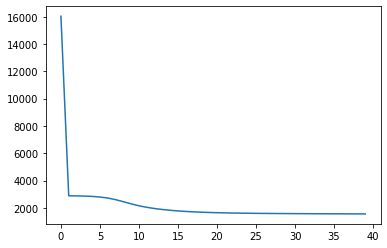

In [57]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [35]:
# for topic_name in model_artm.topic_names:
#     print topic_name + ': ',
#     for word in model_artm.score_tracker["top_words"].last_topic_info[topic_name].tokens:
#         print word,
#     print

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(topic_name + ': ', end=" ")? (<ipython-input-35-3acdd40ccccc>, line 2)

In [58]:
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print('\n', topic_name)
    for token in top_tokens.last_tokens[topic_name]:
        print(token)


 sbj0
человек
быть
также
для
как
право
являться
это
так
они
ребенок
мочь
который
иметь
время

 sbj1
что
его
свой
который
образ
она
этот
это
они
герой
быть
однако
главный
такой
весь

 sbj2
слово
сила
предложение
например
или
который
как
если
это
когда
что
такой
один
часть
мочь

 sbj3
тело
что
это
энергия
вода
этот
ядро
как
масса
земля
такой
движение
мочь
который
при

 sbj4
что
который
это
весь
этот
пушкин
свой
поэт
для
быть
стихотворение
русский
год
как
становиться

 sbj5
x
быть
a
число
b
функция
при
получать
этот
уравнение
если
точка
два
следующий
корень

 sbj6
человек
жизнь
свой
его
произведение
герой
литература
который
как
русский
что
мир
рассказ
автор
писатель

 sbj7
который
общество
развитие
человек
государство
социальный
политический
век
себя
новый
культура
процесс
государственный
власть
отношение

 sbj8
страна
территория
государство
население
этот
северный
часть
также
природный
мир
африка
являться
сша
производство
регион

 sbj9
быть
год
война
который
становиться
первый
после
гор

Давайте посмотрим также на разреженность матриц:

In [59]:
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.6426175832748413
0.0008403361425735056


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [60]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [61]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [62]:
for topic_name in model_artm.topic_names:
    print('\n', topic_name)
    for token in top_tokens.last_tokens[topic_name]:
        print(token)


 sbj0
человек
быть
который
также
для
как
право
являться
это
так
они
мочь
иметь
ребенок
время

 sbj1
что
свой
его
который
она
образ
этот
это
они
быть
однако
главный
такой
весь
самый

 sbj2
слово
сила
предложение
например
или
который
если
как
когда
это
такой
что
часть
один
работа

 sbj3
что
тело
это
энергия
вода
этот
ядро
как
масса
быть
при
такой
движение
земля
мочь

 sbj4
что
который
весь
это
этот
быть
свой
пушкин
поэт
для
русский
становиться
стихотворение
год
его

 sbj5
x
быть
a
число
b
функция
при
получать
уравнение
если
этот
точка
два
следующий
корень

 sbj6
человек
жизнь
свой
произведение
его
герой
литература
который
мир
русский
как
автор
рассказ
писатель
литературный

 sbj7
который
общество
государство
развитие
социальный
человек
век
политический
культура
новый
экономический
процесс
себя
отношение
жизнь

 sbj8
страна
территория
население
государство
этот
часть
северный
также
являться
природный
мир
африка
сша
регион
хозяйство

 sbj9
быть
год
война
который
становиться
первый
после
г

Попробуем менять коэффициент регуляризации:

In [63]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [64]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [65]:
for topic_name in model_artm.topic_names:
    print('\n', topic_name)
    for token in top_tokens.last_tokens[topic_name]:
        print(token)


 sbj0
являться
так
мочь
также
иметь
другой
каждый
основной
право
ребенок
язык
часто
должный
понятие
свобода

 sbj1
что
его
она
самый
главный
однако
образ
друг
сам
история
поэтому
характер
даже
понимать
жить

 sbj2
или
сила
слово
например
пример
предложение
когда
форма
случай
действие
работа
второй
вопрос
помощь
простой

 sbj3
тело
земля
происходить
энергия
вода
сторона
наш
количество
ядро
масса
чем
движение
различный
изменение
состоять

 sbj4
весь
русский
очень
уже
еще
пушкин
поэт
место
природа
стихотворение
где
путь
появляться
конец
множество

 sbj5
при
x
a
если
два
число
вид
можно
b
функция
получать
равный
уравнение
точка
некоторый

 sbj6
человек
свой
жизнь
герой
произведение
мир
литература
автор
литературный
личность
через
всегда
писатель
рассказ
показывать

 sbj7
государство
общество
век
новый
представлять
развитие
период
более
отношение
социальный
политический
процесс
многий
создавать
власть

 sbj8
страна
часть
территория
большой
население
находиться
высокий
здесь
северный
мирово

In [66]:
# еще раз посмотрим на разреженность
print(model_artm.score_tracker["SparsityPhiScore"].last_value)
print(model_artm.score_tracker["SparsityThetaScore"].last_value)

0.899664580821991
0.00756302522495389


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [67]:
model_artm.save("my_model")

In [ ]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [68]:
phi = model_artm.get_phi()

In [69]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
"(text, домохозяйка)",0.0,0.000000,0.000084,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
"(text, институт)",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.001955,0.0,0.0
"(text, машинка)",0.0,0.000000,0.000000,0.0,0.000096,0.0,0.000000,0.000000,0.0,0.0
"(text, прочий)",0.0,0.000527,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
"(text, навязнуть)",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000117,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
"(text, задабривать)",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000059,0.000000,0.0,0.0
"(text, шаманский)",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000059,0.000000,0.0,0.0
"(text, усопший)",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000059,0.000000,0.0,0.0
"(text, рисование)",0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000059,0.000000,0.0,0.0


Матрица вероятностей тем в документах.

In [70]:
theta = model_artm.get_theta()
theta

,400,401,402,403,404,405,406,407,408,409,...,290,291,292,293,294,295,296,297,298,299
sbj0,0.050505,0.040836,0.051282,0.131579,0.344828,0.043062,0.059441,0.019011,0.031469,0.064935,...,0.032468,0.419929,0.082237,0.038462,0.083333,0.025105,0.485010,0.058824,0.027778,0.063604
sbj1,0.077441,0.159544,0.058608,0.013177,0.051724,0.004785,0.073427,0.098859,0.062937,0.060606,...,0.087662,0.032028,0.052632,0.317308,0.111111,0.037657,0.038462,0.304498,0.100694,0.077739
sbj2,0.350168,0.027244,0.014652,0.146199,0.047414,0.038278,0.523202,0.045627,0.041958,0.690839,...,0.024217,0.042705,0.052632,0.047033,0.031486,0.054393,0.042735,0.069204,0.295139,0.035336
sbj3,0.215488,0.016144,0.010989,0.008772,0.064655,0.000000,0.024476,0.551331,0.027972,0.030303,...,0.014382,0.028470,0.351974,0.024038,0.023148,0.008368,0.029915,0.024221,0.381944,0.512367
sbj4,0.050505,0.400107,0.036630,0.027430,0.025862,0.023923,0.052448,0.049430,0.034965,0.021645,...,0.055195,0.007117,0.013158,0.250000,0.334255,0.029289,0.014990,0.124567,0.013889,0.035336
sbj5,0.134680,0.019943,0.010989,0.593896,0.051724,0.818182,0.048951,0.091255,0.013986,0.038961,...,0.022727,0.035587,0.009868,0.014423,0.025463,0.786611,0.038462,0.027682,0.076389,0.063604
sbj6,0.057239,0.072175,0.021978,0.008772,0.056034,0.014354,0.083916,0.015209,0.052448,0.045815,...,0.054100,0.024911,0.059211,0.221196,0.034722,0.012552,0.081197,0.197232,0.020833,0.049470
sbj7,0.016835,0.044634,0.375178,0.008772,0.318966,0.009569,0.046728,0.060837,0.153846,0.025974,...,0.113636,0.266904,0.128289,0.024038,0.067130,0.025105,0.213675,0.058824,0.031250,0.042403
sbj8,0.010101,0.022792,0.038741,0.029240,0.012931,0.009569,0.055944,0.026616,0.157343,0.007934,...,0.087662,0.042705,0.187500,0.015425,0.011574,0.008368,0.038462,0.006920,0.010417,0.045936
sbj9,0.037037,0.196581,0.380952,0.032164,0.025862,0.038278,0.031469,0.041825,0.423077,0.012987,...,0.507950,0.099644,0.062500,0.048077,0.277778,0.012552,0.017094,0.128028,0.041667,0.074205


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [ ]:
theta_test = model_artm.transform(batch_vectorizer, num_document_passes=10)